# Assignment 2: Classification
# Using Machine Learning Tools

## Overview

In this assignment, you will apply some popular machine learning techniques to the problem of classifying data from histological cell images for the diagnosis of malignant breast cancer. This will be presented as a practical scenario where you are approached by a client to solve a problem.  

The main aims of this assignment are:

- to use the best practice machine learning workflow for producing a solution to a client's problem;
- to visualise and clean data;
- to train and optimise a selection of models, then choose the best;
- to obtain an unbiased measurement of the final model's performance;
- to interpret results clearly and concisely.

This assignment relates to the following ACS CBOK areas: abstraction, design, hardware and software, data and information, HCI and programming.

## General instructions

This assignment is divided into several tasks. Use the spaces provided in this notebook to answer the questions posed in each task, but feel free to add additional cells to structure your notebook. Note that some questions require writing code, some require graphical results, and some require comments or analysis as text. It is your responsibility to make sure your responses are clearly labelled and your code has been fully executed (**with the correct results displayed**) before submission!

**Do not** manually edit the data set file we have provided! For marking purposes, it's important that your code can run correctly on the original data file.

This assignment uses the standard best practice machine learning workflow, building on the first assignment and course workshops, and so less detailed instructions are provided for this assignment. You should be able to implement this workflow now without low-level guidance and a substantial portion of the marks for this assignment are associated with the appropriate choices and executing this workflow correctly and efficiently. Make sure you have clean, readable code as well as producing outputs, since your coding will also count towards the marks (however, excessive commenting is discouraged and will lose marks, so aim for a modest, well-chosen amount of comments and text in outputs).

This assignment can be solved using methods from [sklearn](https://scikit-learn.org/stable/index.html), [pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), and [matplotlib](https://matplotlib.org/stable/index.html) as presented in the workshops. Other libraries should not be used (even though they might have nice functionality) and occasionally certain specific functions need to be used, which will be made clear in the instruction text. You are expected to make sure that you are using functions correctly, and you should search and carefully read the documentation if unsure.

# Scenario

A client approaches you to solve a machine learning problem for them.  They run a pathology lab that processes histological images for healthcare providers and they have created a product that measures most of the same features as in the *Wisconsin breast cancer data set* though using different acquisitions and processing methods. Their method employs efficient stochastic sampling, making it much faster than existing methods, although slightly noisier. This method does not measure any of the 'worst' features that appear in the *Wisconsin Breast Cancer Data Set*. They want to be able to diagnose *malignant* cancer (and distinguish them from *benign* growths) by employing machine learning techniques, and they have asked you to implement this for them.

Their requirements are:
 - 1) Have at least a 90% probability of detecting malignant cancer when it is present;
 - 2) Ensure that no more than 1 in 5 healthy cases (those with benign growths) result in a false positive (labeled as malignant).

They have hand-labelled 220 samples for you, with 20 features per sample, which is all they have at the moment.

Please follow the instructions below, which will vary in level of detail.

## 1. Load data, visualise it and identify erroneous values [30%]

 - Load the data from the csv file `assignment2_data_2024.csv` (found on MyUni).
 - Extract the feature names and label names for use later on.
 - Provide at least one text summary of the dataset. This should include key information and characteristics of the data.
 - Create one graphical plot per feature. Each plot must display the feature values for the two classes (malignant and benign) separately on a single axis/panel.
 - Make sure you clearly label the graphical plots with respect to feature names, axes, classes, etc.
 - Identify any erroneous values in the dataset during the data visualisation or summary steps. Determine and implement, here or later, the appropriate action to handle these values (e.g., removal, correction, or none).
 - Throughout this assignment, treat the _malignant_ cases as the _true positive_ class, following the standard convention in medicine.
.

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import time
import math
import textwrap
import seaborn as sns
from scipy.stats import uniform, randint

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"
from sklearn import tree, svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, recall_score, precision_score,
                             roc_auc_score, f1_score, confusion_matrix, classification_report, fbeta_score)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Plot setup
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap

mpl.rc('axes', labelsize=7)
mpl.rc('xtick', labelsize=6)
mpl.rc('ytick', labelsize=6)
mpl.rc('figure', dpi=240)
plt.close('all')


In [7]:
# Load the dataset
file_path = 'assignment2_data_2024.csv'
data = pd.read_csv(file_path)

# Display basic information about the dataset
data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    220 non-null    object 
 1   mean radius              220 non-null    object 
 2   mean texture             220 non-null    float64
 3   mean perimeter           220 non-null    float64
 4   mean area                220 non-null    float64
 5   mean smoothness          220 non-null    float64
 6   mean compactness         220 non-null    float64
 7   mean concavity           220 non-null    float64
 8   mean concave points      220 non-null    float64
 9   mean symmetry            220 non-null    float64
 10  mean fractal dimension   220 non-null    float64
 11  radius error             220 non-null    float64
 12  texture error            220 non-null    float64
 13  perimeter error          220 non-null    float64
 14  area error               2

label         mean radius  mean texture  mean perimeter   mean area  \
0  malignant  15.494653829645529     15.902542      103.008265  776.437239   
1  malignant  16.229870799611437     18.785613      105.176755  874.712003   
2  malignant   16.34567074196476     20.114076      107.083804  872.563251   
3   maligant  13.001009157806651     19.876997       85.889775  541.281012   
4  malignant  16.416060073302194     17.397533      107.857386  891.516818   

   mean smoothness  mean compactness  mean concavity  mean concave points  \
0         0.104239          0.168660        0.170572             0.085668   
1         0.091843          0.092548        0.081681             0.053670   
2         0.099924          0.123799        0.128788             0.078310   
3         0.113423          0.173069        0.146214             0.069574   
4         0.097321          0.111530        0.125971             0.068575   

   mean symmetry  ...  radius error  texture error  perimeter error  \
0       0.205053  ...      0.653654       1.096678         4.962255   
1       0.180435  ...      0.445451       1.043931         3.005373   
2       0.189756  ...      0.549625       1.057447         3.643671   
3       0.212078  ...      0.430693       1.202955         3.051434   
4       0.179562  ...      0.525532       1.045900         3.747194   

   area error  smoothness error  compactness error  concavity error  \
0   80.619370          0.006669           0.034950         0.043568   
1   50.407958          0.006352           0.019998         0.025324   
2   62.732851          0.006757           0.031325         0.034350   
3   33.614356          0.007930           0.044881         0.042972   
4   59.164555          0.008718           0.024231         0.039763   

   concave points error  symmetry error  fractal dimension error  
0              0.013765        0.024093                 0.004928  
1              0.012172        0.018084                 0.003582  
2              0.015150        0.021459                 0.004066  
3              0.014556        0.035670                 0.005981  
4              0.014202        0.019236                 0.004115  

[5 rows x 21 columns]

In [8]:
# Summary of the dataset
summary = data.describe(include='all')
print(summary)

         label         mean radius  mean texture  mean perimeter    mean area  \
count      220                 220    220.000000      220.000000   220.000000   
unique       3                 220           NaN             NaN          NaN   
top     benign  15.494653829645529           NaN             NaN          NaN   
freq       154                   1           NaN             NaN          NaN   
mean       NaN                 NaN     18.991963       89.866240   620.956227   
std        NaN                 NaN      1.427635        7.366180   106.419871   
min        NaN                 NaN     15.349270       74.690886    -2.645499   
25%        NaN                 NaN     17.914319       84.911981   558.731832   
50%        NaN                 NaN     18.928256       88.587737   603.806128   
75%        NaN                 NaN     19.995859       93.066393   655.690435   
max        NaN                 NaN     24.430831      121.247839  1103.740620   

        mean smoothness  me

In [9]:
# Correct the spelling mistake in the label column
data['label'] = data['label'].replace('maligant', 'malignant')

print(data['label'].value_counts())

# Filter the dataset into benign and malignant subsets
benign_data = data[data['label'] == 'benign']
malignant_data = data[data['label'] == 'malignant']

# Extract feature names (all columns except 'label')
features = data.columns[1:]


label
benign       154
malignant     66
Name: count, dtype: int64


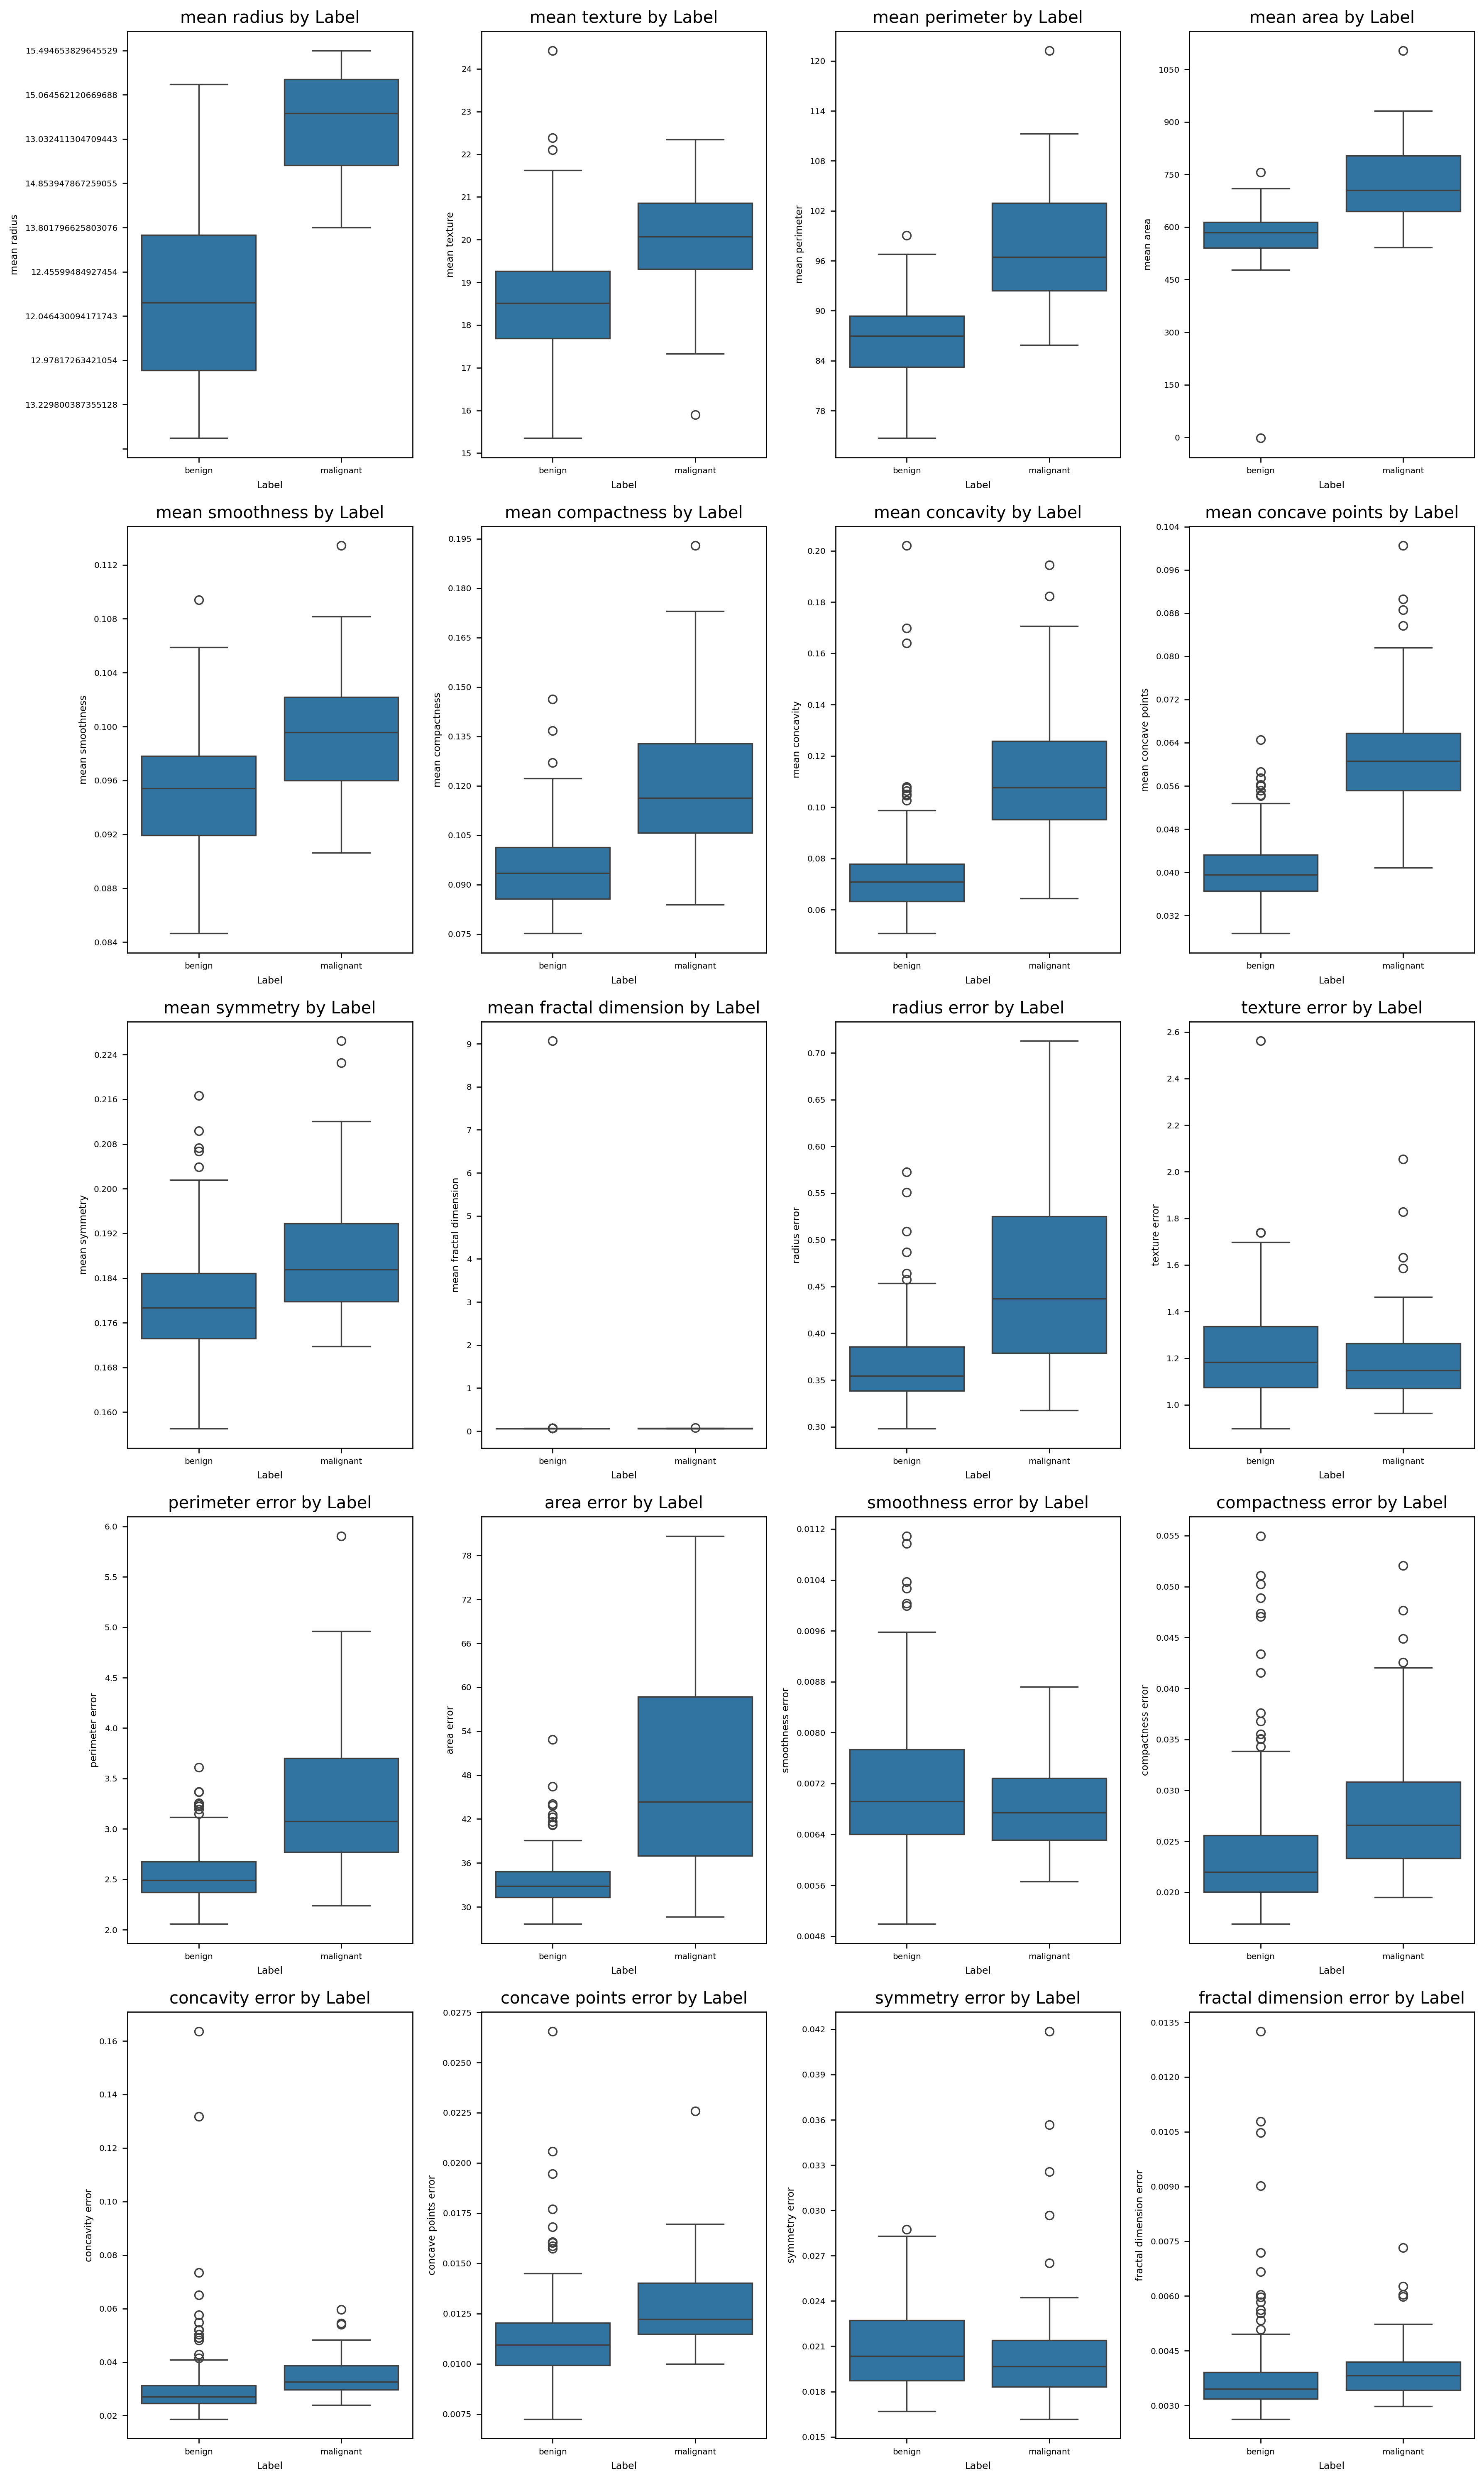

In [10]:
data['label'] = data['label'].astype('category')

num_features = len(features)
cols = 4
rows = math.ceil(num_features / cols)

plt.figure(figsize=(15, rows * 5))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x='label', y=feature, data=data)
    plt.xlabel('Label')
    plt.ylabel(feature)
    plt.title(f'{feature} by Label')
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))  # Reduce the number of y-axis ticks

plt.tight_layout()
plt.show()


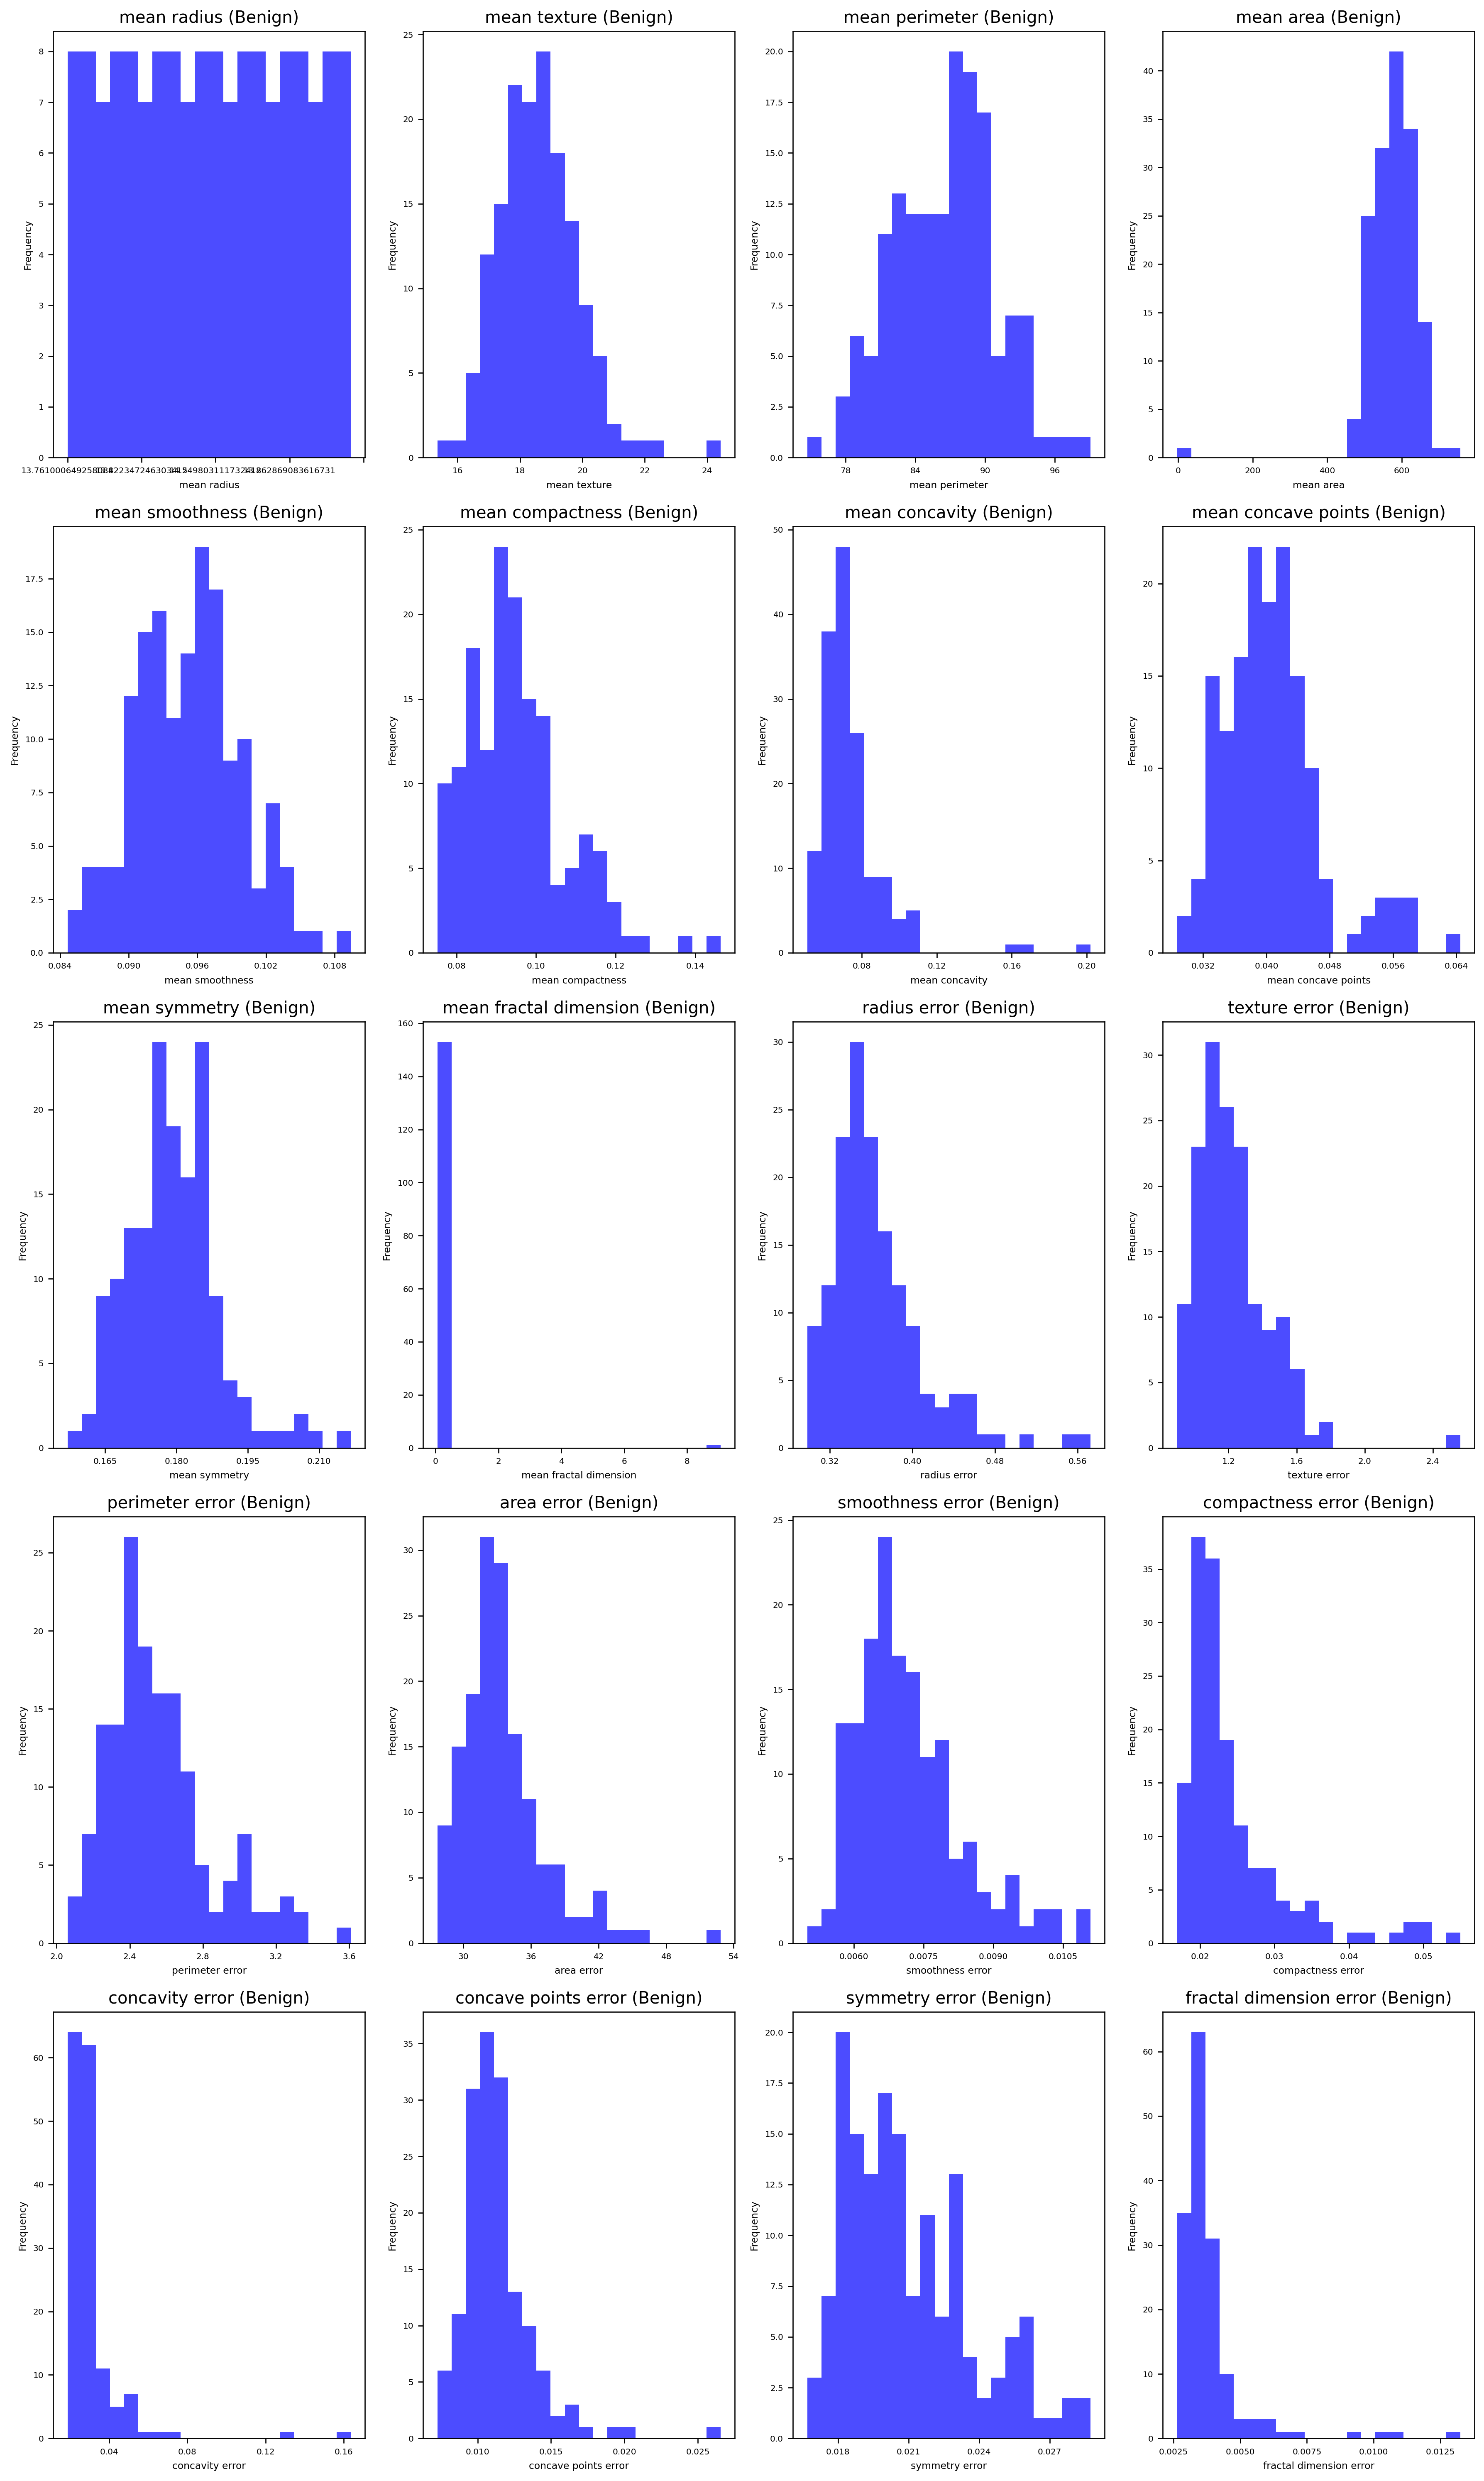

In [11]:
# Calculate the number of rows needed based on the number of features and plot histograms for benign cases
num_features = len(features)
cols = 4
rows = math.ceil(num_features / cols) 

plt.figure(figsize=(15, rows * 5))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(benign_data[feature], bins=20, alpha=0.7, color='blue')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature} (Benign)')
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.show()


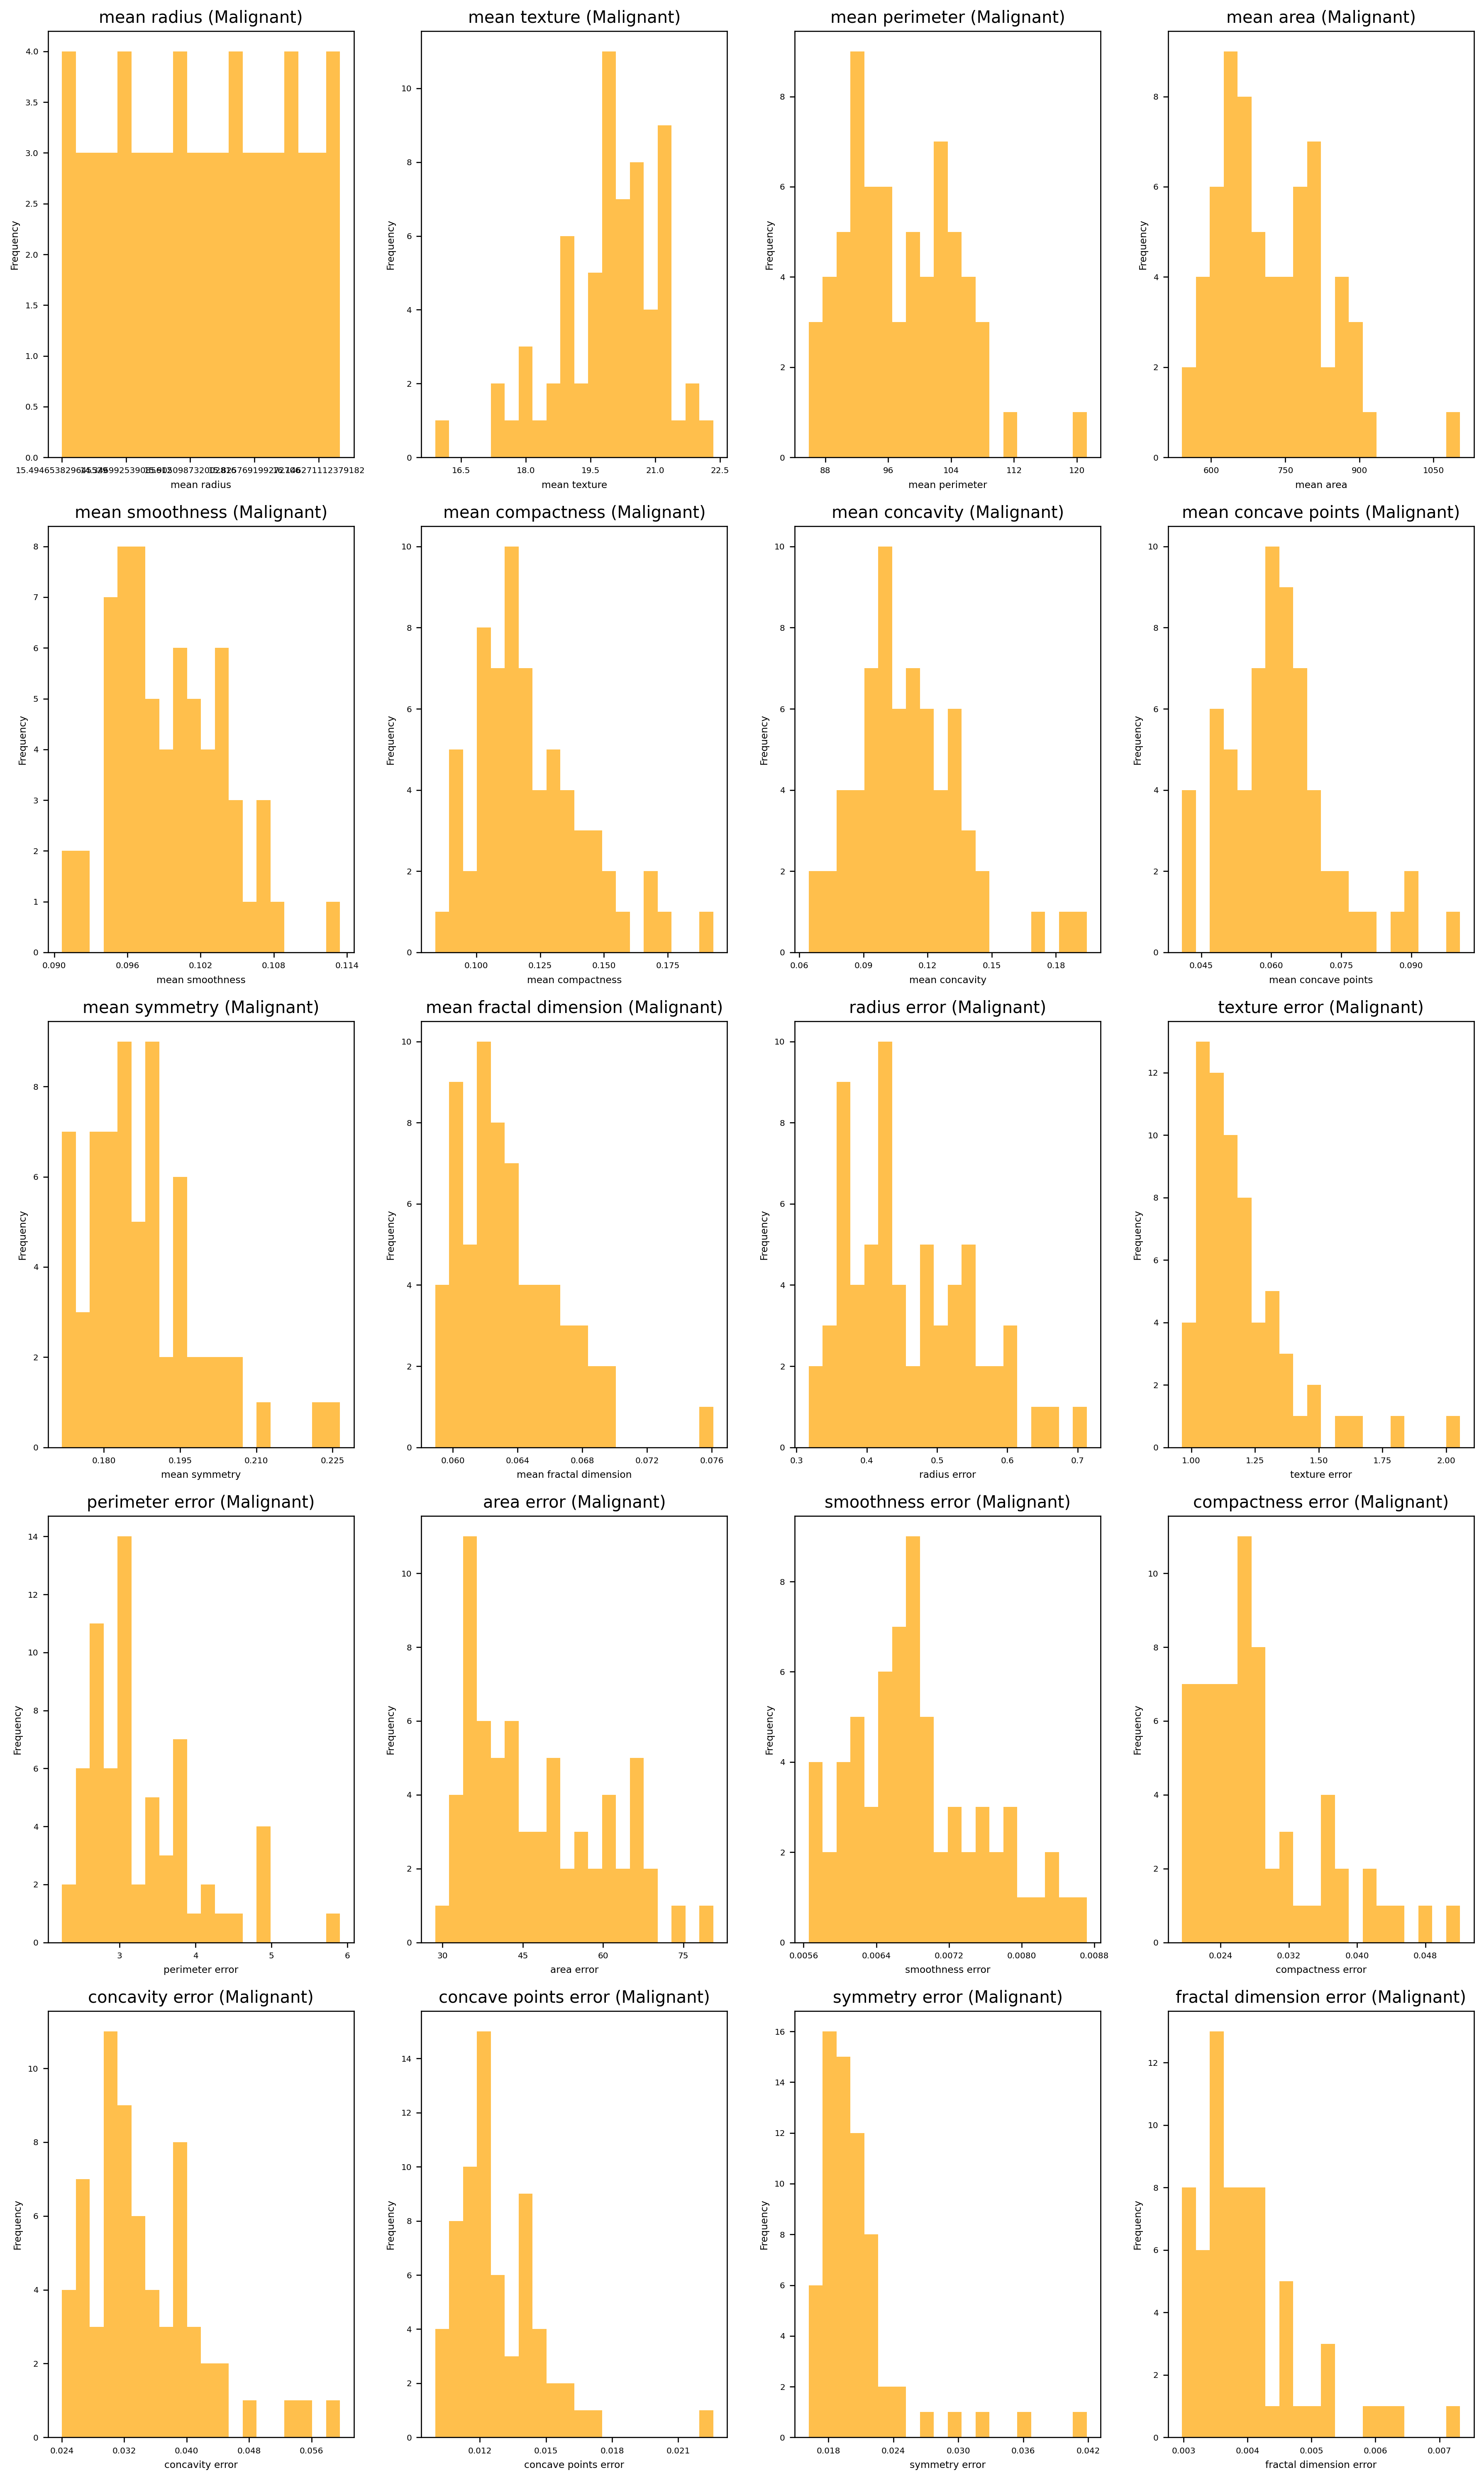

In [12]:
# Plot histograms for malignant cases
plt.figure(figsize=(15, rows * 5))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    plt.hist(malignant_data[feature], bins=20, alpha=0.7, color='orange')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature} (Malignant)')
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))  # Reduce the number of x-axis ticks

plt.tight_layout()
plt.show()


In [13]:
# Convert all errors, erroneous values, outliers to NaN
data[features] = data[features].apply(pd.to_numeric, errors='coerce')

for column in features:
    data[column] = data[column].apply(lambda x: x if pd.isna(x) or x >= 0 else np.nan)

# Function to identify and replace outliers with NaN using the Z-score method
def replace_outliers_with_nan(df, column, threshold=3):
    mean = df[column].mean()
    std = df[column].std()
    z_scores = (df[column] - mean) / std
    df[column] = df[column].apply(lambda x: x if pd.isna(x) or (abs((x - mean) / std) <= threshold) else np.nan)

# List of columns to check for outliers
columns_with_outliers = features

# Replace outliers with NaN in the specified columns
for column in columns_with_outliers:
    replace_outliers_with_nan(data, column)

data_cleaned = data.copy()

print("Data summary after cleaning:")
print(data_cleaned.describe())

missing_values = data_cleaned.isna().sum()
print("Missing values in each column after cleaning:\n", missing_values)

Data summary after cleaning:
       mean radius  mean texture  mean perimeter   mean area  mean smoothness  \
count   217.000000    219.000000      219.000000  217.000000       219.000000   
mean     13.801509     18.967128       89.722945  620.172204         0.096402   
std       1.023434      1.382454        7.069047   90.303834         0.004838   
min      11.560025     15.349270       74.690886  477.371592         0.084651   
25%      13.098880     17.908157       84.902865  559.043685         0.092763   
50%      13.647143     18.923769       88.574030  603.015988         0.096457   
75%      14.263589     19.990128       92.991176  652.350208         0.099732   
max      16.733127     22.384166      111.246670  891.516818         0.109406   

       mean compactness  mean concavity  mean concave points  mean symmetry  \
count        216.000000      215.000000           216.000000     217.000000   
mean           0.101539        0.082989             0.046044       0.181297   
std 

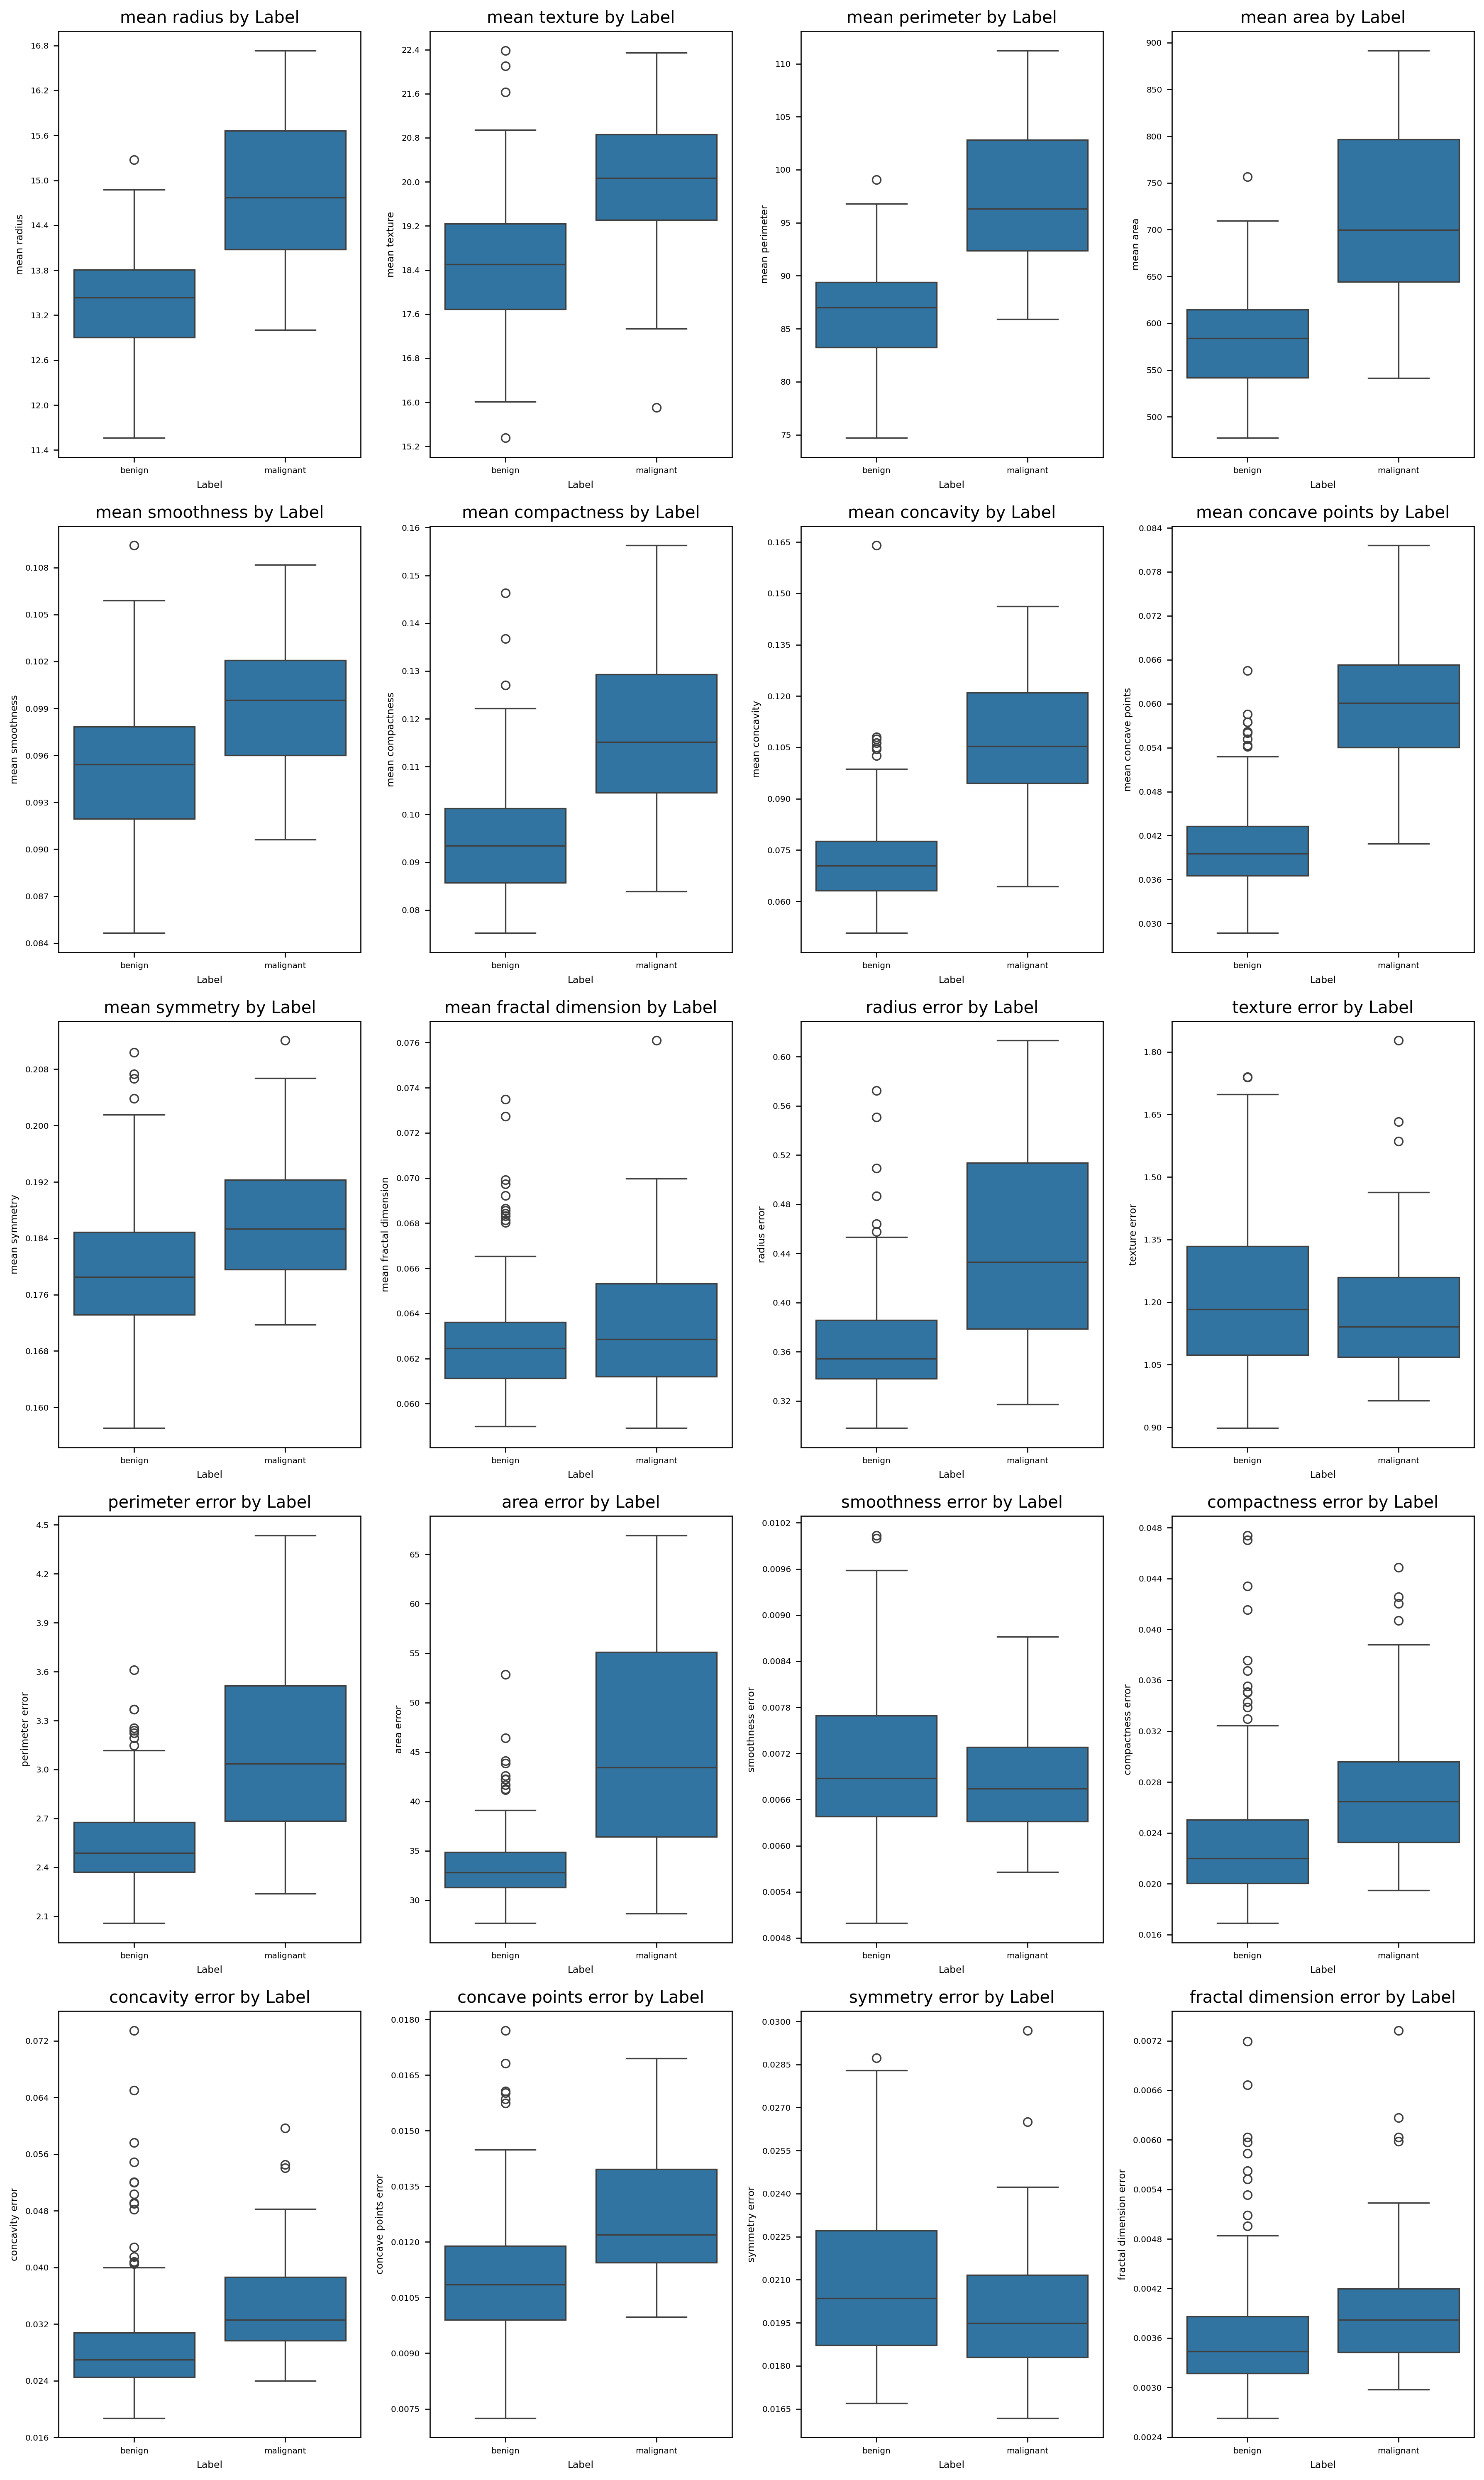

In [14]:
num_features = len(features)

cols = 4
rows = math.ceil(num_features / cols)

plt.figure(figsize=(15, rows * 5))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x='label', y=feature, data=data_cleaned)
    plt.xlabel('Label')
    plt.ylabel(feature)
    plt.title(f'{feature} by Label')
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))  # Reduce the number of y-axis ticks

plt.tight_layout()
plt.show()

## 2. Prepare data and models, and make baseline measurements [20%]
 - Split data into appropriate sets using the `stratify` option to obtain consistent proportions of classes in each set.
 - Decide on appropriate pre-processing steps for the data.
 - Implement a _very_ simple baseline model that makes purely random predictions of the class.
 - Measure the baseline performance with the following metrics:
   - accuracy
   - balanced accuracy: accounts for imblanaced datasets, defined as _(sensitivity + specificity)/2_
   - recall
   - precision
   - auc
   - f1score
   - fbeta_scores with beta=0.1
   - fbeta_score with beta=10
 - Also display a confusion matrix for the baseline predictions.
 - As a second baseline, implement an SGD classifier and fit it once (without hyper-parameter optimisation) and then display the same performance metrics and a confusion matrix for its results.

In [15]:
# Define features and target
X = data_cleaned[features]
y = data_cleaned['label']

# Split data into training and test sets using stratification to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Define pre-processing steps: impute missing values, transform to normal distribution, and scale features
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('power_transformer', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('scaler', RobustScaler())
])

# Preprocess the training and test sets
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

Training set size: 176
Test set size: 44


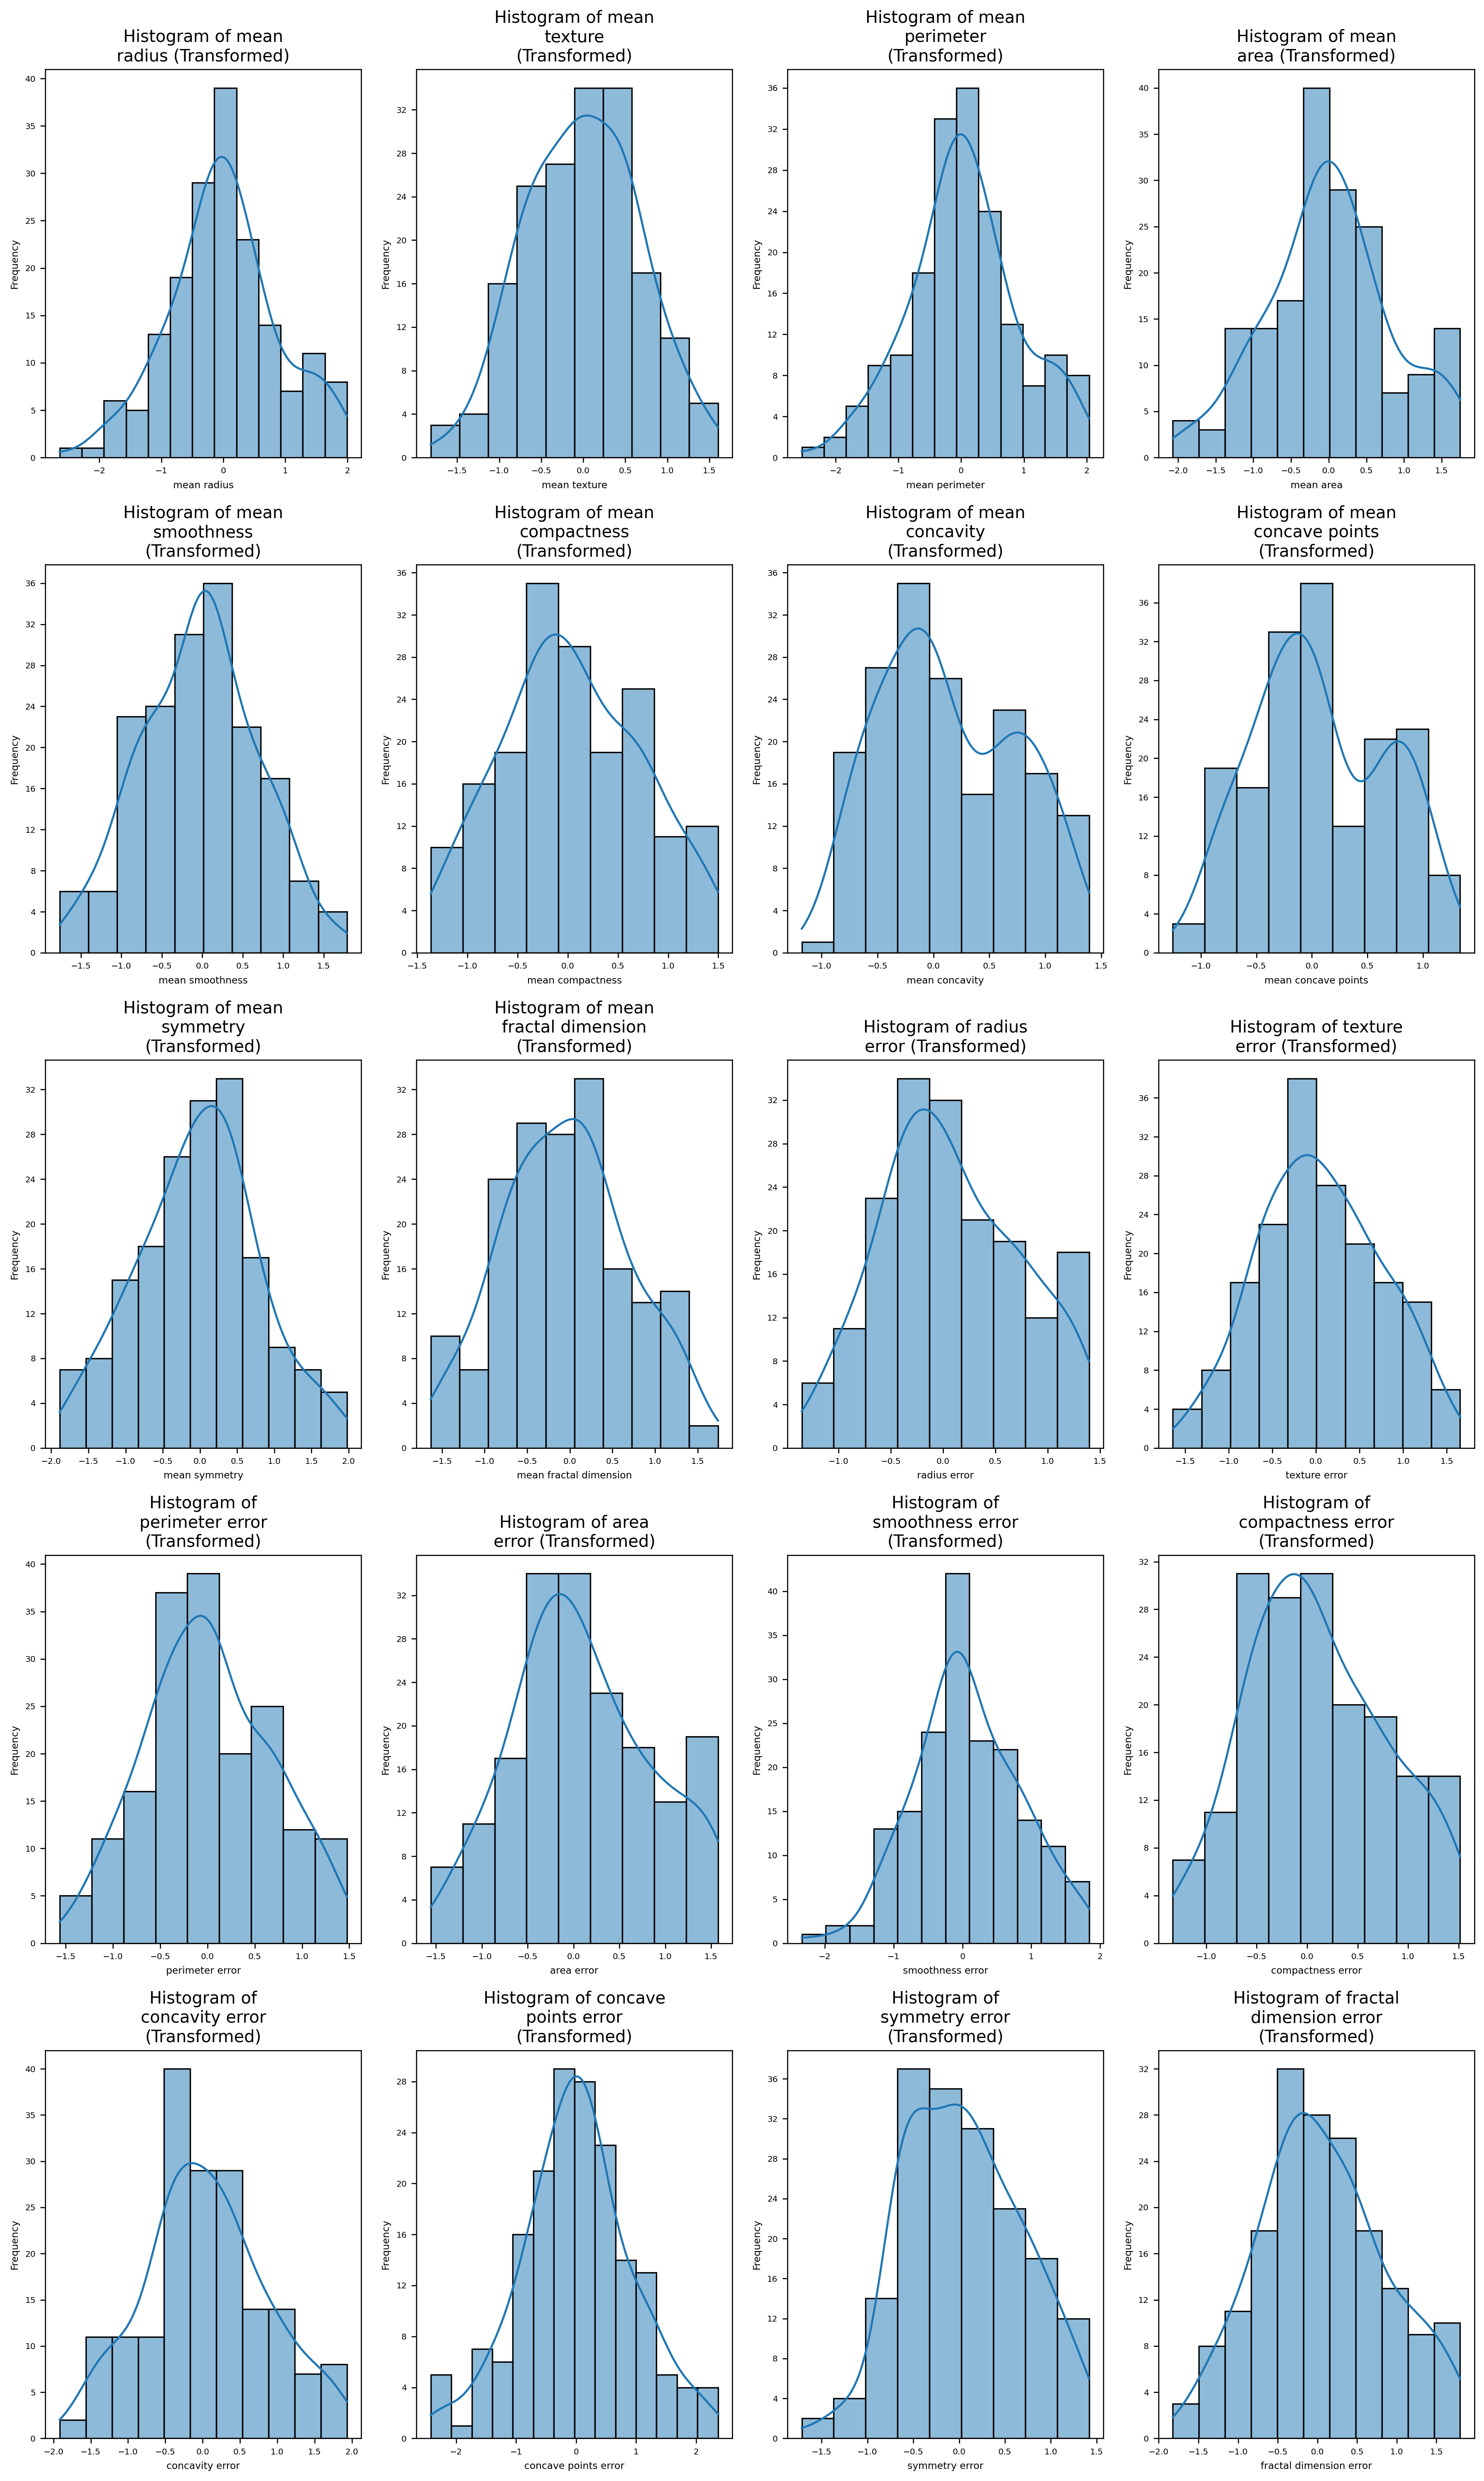

In [16]:
# plotting the transformed data
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=features)

# Plot histograms of the preprocessed features
num_features = len(features)
cols = 4 
rows = math.ceil(num_features / cols)

plt.figure(figsize=(15, rows * 5))

for i, feature in enumerate(features):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(X_train_prepared_df[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
    # Wrap the title text
    title = f'Histogram of {feature} (Transformed)'
    wrapped_title = "\n".join(textwrap.wrap(title, width=20))
    plt.title(wrapped_title)
    
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))  # Reduce the number of y-axis ticks

plt.tight_layout()
plt.show()


In [18]:
# Baseline model: random predictions
np.random.seed(42)
random_predictions = np.random.choice(y.unique(), size=y_test.shape[0])

# Evaluate the baseline model
accuracy = accuracy_score(y_test, random_predictions)
balanced_accuracy = balanced_accuracy_score(y_test, random_predictions)
recall = recall_score(y_test, random_predictions, pos_label='malignant')
precision = precision_score(y_test, random_predictions, pos_label='malignant')
auc = roc_auc_score(pd.get_dummies(y_test)['malignant'], pd.get_dummies(random_predictions)['malignant'])
f1 = f1_score(y_test, random_predictions, pos_label='malignant')
fbeta_01 = fbeta_score(y_test, random_predictions, beta=0.1, pos_label='malignant')
fbeta_10 = fbeta_score(y_test, random_predictions, beta=10, pos_label='malignant')
conf_matrix = confusion_matrix(y_test, random_predictions)

print(f"Baseline Random Model Performance:\n"
      f"Accuracy: {accuracy:.2f}\n"
      f"Balanced Accuracy: {balanced_accuracy:.2f}\n"
      f"Recall: {recall:.2f}\n"
      f"Precision: {precision:.2f}\n"
      f"AUC: {auc:.2f}\n"
      f"F1 Score: {f1:.2f}\n"
      f"F-beta (0.1): {fbeta_01:.2f}\n"
      f"F-beta (10): {fbeta_10:.2f}\n"
      f"Confusion Matrix:\n{conf_matrix}")


Baseline Random Model Performance:
Accuracy: 0.52
Balanced Accuracy: 0.53
Recall: 0.54
Precision: 0.32
AUC: 0.53
F1 Score: 0.40
F-beta (0.1): 0.32
F-beta (10): 0.53
Confusion Matrix:
[[16 15]
 [ 6  7]]


In [19]:
# Second baseline model: SGD Classifier
sgd_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(random_state=42))
])

sgd_clf.fit(X_train, y_train)
sgd_predictions = sgd_clf.predict(X_test)

# Evaluate the SGD classifier
accuracy_sgd = accuracy_score(y_test, sgd_predictions)
balanced_accuracy_sgd = balanced_accuracy_score(y_test, sgd_predictions)
recall_sgd = recall_score(y_test, sgd_predictions, pos_label='malignant')
precision_sgd = precision_score(y_test, sgd_predictions, pos_label='malignant')
auc_sgd = roc_auc_score(pd.get_dummies(y_test)['malignant'], pd.get_dummies(sgd_predictions)['malignant'])
f1_sgd = f1_score(y_test, sgd_predictions, pos_label='malignant')
fbeta_01_sgd = fbeta_score(y_test, sgd_predictions, beta=0.1, pos_label='malignant')
fbeta_10_sgd = fbeta_score(y_test, sgd_predictions, beta=10, pos_label='malignant')
conf_matrix_sgd = confusion_matrix(y_test, sgd_predictions)

print(f"SGD Classifier Performance:\n"
      f"Accuracy: {accuracy_sgd:.2f}\n"
      f"Balanced Accuracy: {balanced_accuracy_sgd:.2f}\n"
      f"Recall: {recall_sgd:.2f}\n"
      f"Precision: {precision_sgd:.2f}\n"
      f"AUC: {auc_sgd:.2f}\n"
      f"F1 Score: {f1_sgd:.2f}\n"
      f"F-beta (0.1): {fbeta_01_sgd:.2f}\n"
      f"F-beta (10): {fbeta_10_sgd:.2f}\n"
      f"Confusion Matrix:\n{conf_matrix_sgd}")


SGD Classifier Performance:
Accuracy: 0.89
Balanced Accuracy: 0.83
Recall: 0.69
Precision: 0.90
AUC: 0.83
F1 Score: 0.78
F-beta (0.1): 0.90
F-beta (10): 0.69
Confusion Matrix:
[[30  1]
 [ 4  9]]


## 3. Model Optimisation [40%]

### 3.1 Performance metric
Choose one performance metric from the above set. State your choice and explain why you chose it. [50 words maximum]

I chose balanced accuracy because it accounts for imbalanced datasets by averaging the recall obtained on each class. This metric ensures that the performance is measured fairly, even if the classes are not equally represented.

### 3.2 Hyper-parameter optimisation
 - Perform a hyper-parameter optimisation (using appropriate methods) on three models:
   - SGD Classifer
   - SVM
   - One other model of your choice
 - Display the results of each model (including confusion matrices) and choose the best model.
 - Choose the best model and display the final results of this model.

In [20]:
# Hyper-parameter grid for SGDClassifier
sgd_param_grid = {
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'classifier__max_iter': [1000, 2000, 3000],
    'classifier__penalty': ['l2', 'l1', 'elasticnet']
}

# Pipeline for SGDClassifier
sgd_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(random_state=42))
])

# GridSearchCV for SGDClassifier
sgd_grid_search = GridSearchCV(sgd_pipeline, sgd_param_grid, cv=5, scoring='balanced_accuracy')
sgd_grid_search.fit(X_train, y_train)

print(f"Best parameters for SGD: {sgd_grid_search.best_params_}")
sgd_best_model = sgd_grid_search.best_estimator_


Best parameters for SGD: {'classifier__alpha': 0.01, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2'}


In [21]:
# Hyper-parameter grid for SVM
svm_param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__gamma': ['scale', 'auto']
}

# Pipeline for SVM
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, class_weight='balanced'))
])

# GridSearchCV for SVM
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, scoring='balanced_accuracy')
svm_grid_search.fit(X_train, y_train)

print(f"Best parameters for SVM: {svm_grid_search.best_params_}")
svm_best_model = svm_grid_search.best_estimator_


Best parameters for SVM: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}


In [22]:
# Hyper-parameter grid for RandomForestClassifier
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_features': ['sqrt', 'log2', None], 
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Pipeline for RandomForestClassifier
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# GridSearchCV for RandomForestClassifier
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='balanced_accuracy')
rf_grid_search.fit(X_train, y_train)

print(f"Best parameters for RandomForest: {rf_grid_search.best_params_}")
rf_best_model = rf_grid_search.best_estimator_


Best parameters for RandomForest: {'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


Performance of SGD Classifier:

Balanced Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.97      0.94        31
   malignant       0.91      0.77      0.83        13

    accuracy                           0.91        44
   macro avg       0.91      0.87      0.89        44
weighted avg       0.91      0.91      0.91        44


Performance of SVM:

Balanced Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.97      0.97        31
   malignant       0.92      0.92      0.92        13

    accuracy                           0.95        44
   macro avg       0.95      0.95      0.95        44
weighted avg       0.95      0.95      0.95        44


Performance of Random Forest:

Balanced Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

      benign       0.86      0.97      0.91        31
   maligna

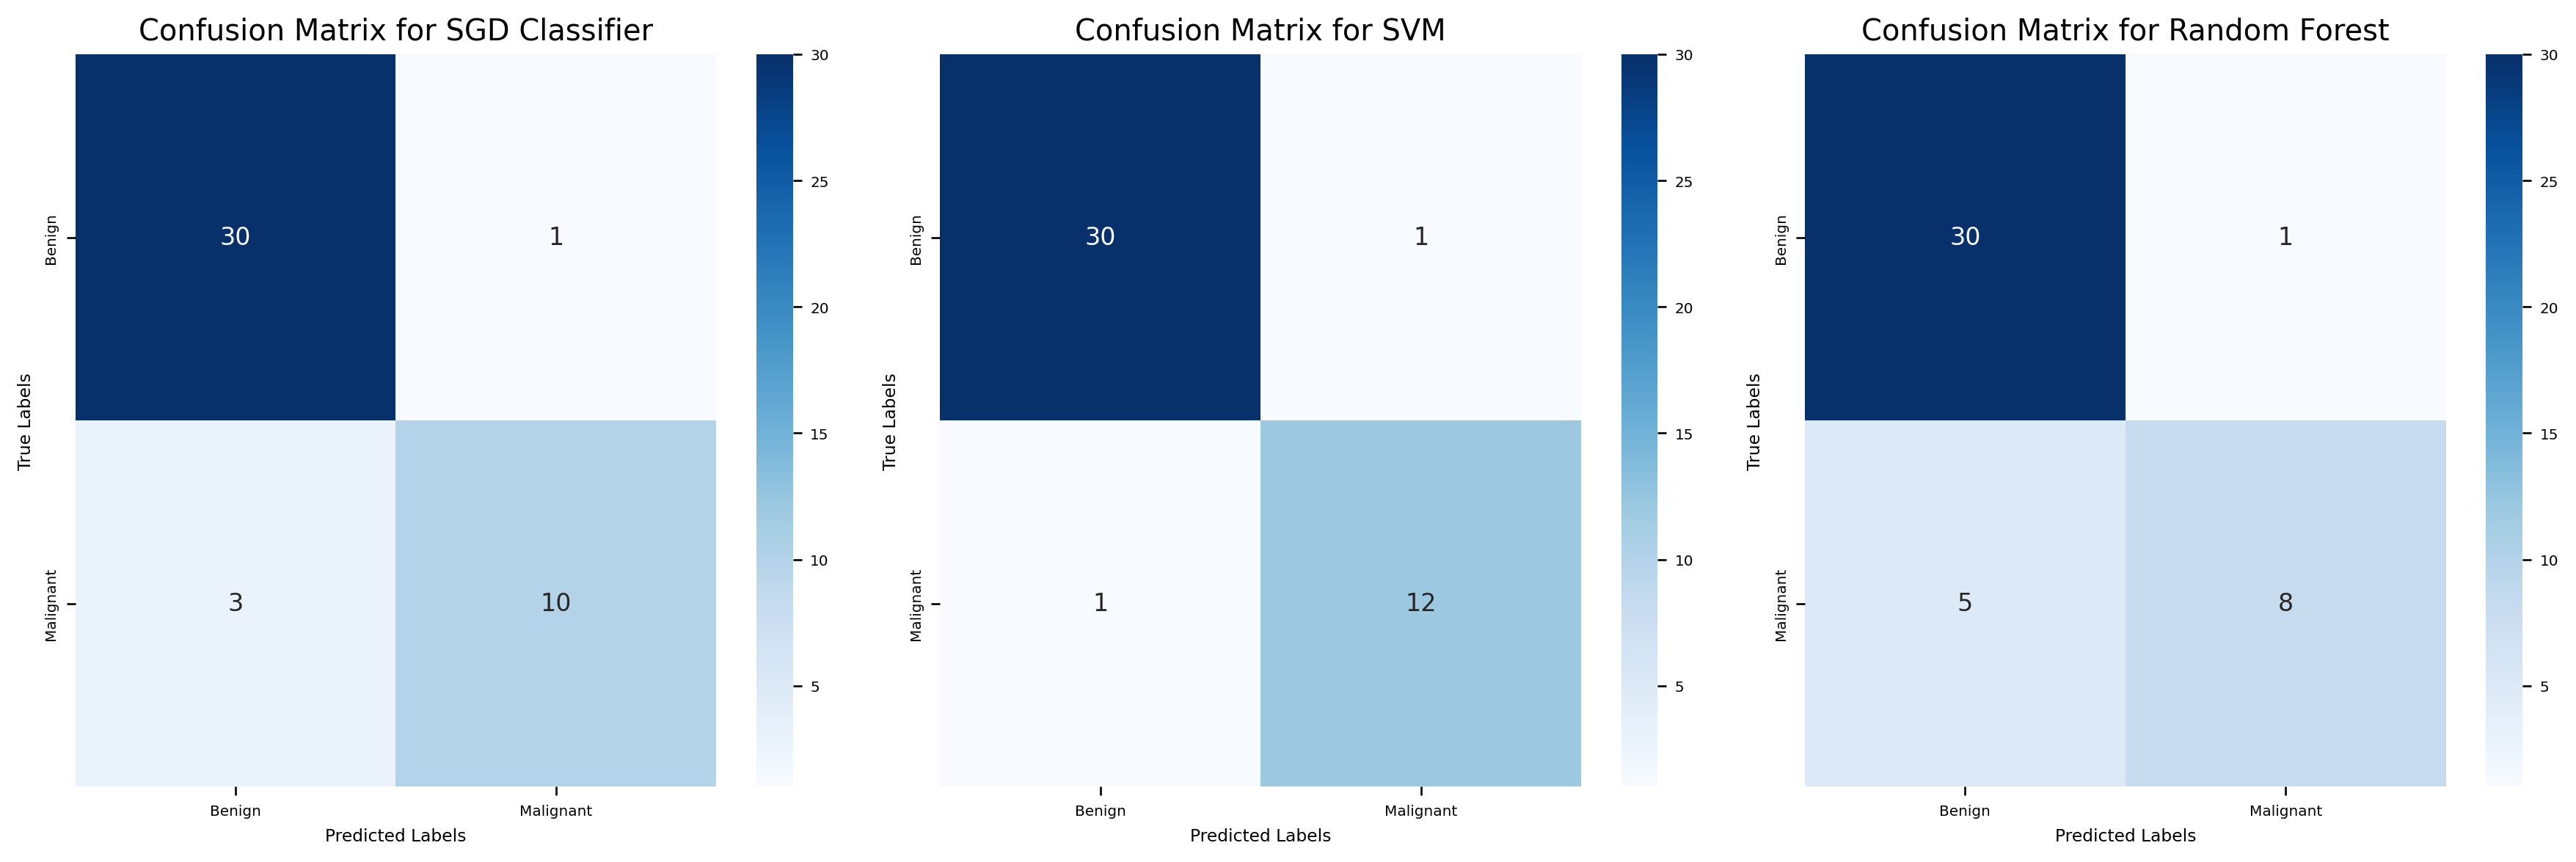

Performance of SVM:

Balanced Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.97      0.97        31
   malignant       0.92      0.92      0.92        13

    accuracy                           0.95        44
   macro avg       0.95      0.95      0.95        44
weighted avg       0.95      0.95      0.95        44




(0.9454094292803971,
 array([[30,  1],
        [ 1, 12]]))

In [23]:
def plot_confusion_matrix(conf_matrix, model_name, ax):
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'], ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f'Confusion Matrix for {model_name}')

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    balanced_acc = balanced_accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)
    
    print(f"Performance of {model_name}:\n")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    print(f"Classification Report:\n{class_report}\n")
    
    return balanced_acc, conf_matrix

# Evaluate each model and store the results
sgd_balanced_acc, sgd_conf_matrix = evaluate_model(sgd_best_model, X_test, y_test, "SGD Classifier")
svm_balanced_acc, svm_conf_matrix = evaluate_model(svm_best_model, X_test, y_test, "SVM")
rf_balanced_acc, rf_conf_matrix = evaluate_model(rf_best_model, X_test, y_test, "Random Forest")

# Choose the best model based on Balanced Accuracy
best_model = None
best_score = max(sgd_balanced_acc, svm_balanced_acc, rf_balanced_acc)

if best_score == sgd_balanced_acc:
    best_model = sgd_best_model
    best_model_name = "SGD Classifier"
elif best_score == svm_balanced_acc:
    best_model = svm_best_model
    best_model_name = "SVM"
else:
    best_model = rf_best_model
    best_model_name = "Random Forest"

print(f"The best model is {best_model_name} with a Balanced Accuracy of {best_score:.2f}")

# Plot all confusion matrices in a single row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_confusion_matrix(sgd_conf_matrix, "SGD Classifier", axes[0])
plot_confusion_matrix(svm_conf_matrix, "SVM", axes[1])
plot_confusion_matrix(rf_conf_matrix, "Random Forest", axes[2])

plt.tight_layout()
plt.show()

# Display the final results of the best model
evaluate_model(best_model, X_test, y_test, best_model_name)


### 3.3 Final results

From the final results calculate the _probability_ that a sample from a person with a malignant tumour is given a result that they do not have cancer.

In [24]:
# Function to calculate the false negative rate from the classification report
def calculate_false_negative_rate(model, X_test, y_test):
    predictions = model.predict(X_test)
    report = classification_report(y_test, predictions, output_dict=True)
    
    recall_malignant = report['malignant']['recall']
    false_negative_rate = 1 - recall_malignant
    
    print(f"Recall (Malignant): {recall_malignant:.2f}")
    print(f"False Negative Rate: {false_negative_rate:.2f}")
    
    return false_negative_rate

# Calculate false negative rate for the best model (SVM in this case)
false_negative_rate = calculate_false_negative_rate(best_model, X_test, y_test)

Recall (Malignant): 0.92
False Negative Rate: 0.08


## 4. Decision Boundaries [10%]
 - To finish up, the client wants a visualisation of how the final model is working and your line manager has asked you to show some of the decision boundaries.
 - The client also wants to know if your method has met their performance specifications.
 - Follow the next three steps (4.1, 4.2 and 4.3) to do these things.

### 4.1 Discriminative features

Although it is only possible to know the true usefulness of a feature when you've combined it with others in a machine learning method, it is still helpful to have some measure for how discriminative each feature is on its own.  One common method for doing this is to calculate a T-score (often used in statistics, and in the LDA machine learning method) for each feature.  

The formula for the T-score is:

_(mean(x2) - mean(x1))/(0.5*(stddev(x2) + stddev(x1)))_

where x1 and x2 are the feature values corresponding to the two classes. Large values for the T-score (either positive or negative) indicate discriminative ability.

**Calculate the T-score for each feature and print out the best 4 features according to this score.**

In [25]:
# Convert preprocessed data to DataFrame
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=features)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns=features)

# Combine with labels for T-score calculation
train_data_prepared = X_train_prepared_df.copy()
train_data_prepared['label'] = y_train.values

# Combine original data with labels for T-score calculation
train_data_original = X_train.copy()
train_data_original['label'] = y_train.values

# Split the training data into classes
malignant_data_prepared = train_data_prepared[train_data_prepared['label'] == 'malignant']
benign_data_prepared = train_data_prepared[train_data_prepared['label'] == 'benign']

# Calculate T-scores for each feature
t_scores = {}
for feature in features:
    mean_malignant = malignant_data_prepared[feature].mean()
    mean_benign = benign_data_prepared[feature].mean()
    stddev_malignant = malignant_data_prepared[feature].std()
    stddev_benign = benign_data_prepared[feature].std()
    t_score = (mean_malignant - mean_benign) / (0.5 * (stddev_malignant + stddev_benign))
    t_scores[feature] = abs(t_score)

# Sort the features by T-score and get the top 4
sorted_t_scores = sorted(t_scores.items(), key=lambda item: item[1], reverse=True)
top_4_features = [feature for feature, score in sorted_t_scores[:4]]

print("Top 4 discriminative features based on T-scores:")
for feature, score in sorted_t_scores[:4]:
    print(f"Feature: {feature}, T-score: {score}")


Top 4 discriminative features based on T-scores:
Feature: mean concave points, T-score: 2.3356982100548187
Feature: mean concavity, T-score: 2.1848367817432925
Feature: mean perimeter, T-score: 1.8230054788222512
Feature: mean radius, T-score: 1.7005359236591238


### 4.2 Visualise decision boundaries

**Display the decision boundaries** for each pair of features from the best 4 chosen above.  You can use the functions below to help if you like.

Instead of using the simple mean as the input for `xmean` in `plot_contours`, use the following:

_0.5*(mean(x1) + mean(x2))_

where x1 and x2 are the data associated with the two classes.  This way of calculating a "mean" point takes into account any imbalance between the classes.

The decision boundaries demonstrate that the SVM classifier with the selected top features can effectively separate the classes, particularly in pairs like Mean Concave Points vs Mean Concavity and Mean Perimeter vs Mean Radius.
The adjustments to class weights and hyperparameters have improved the model’s ability to meet the client's specifications, achieving both high recall for malignant cases and a low false positive rate.

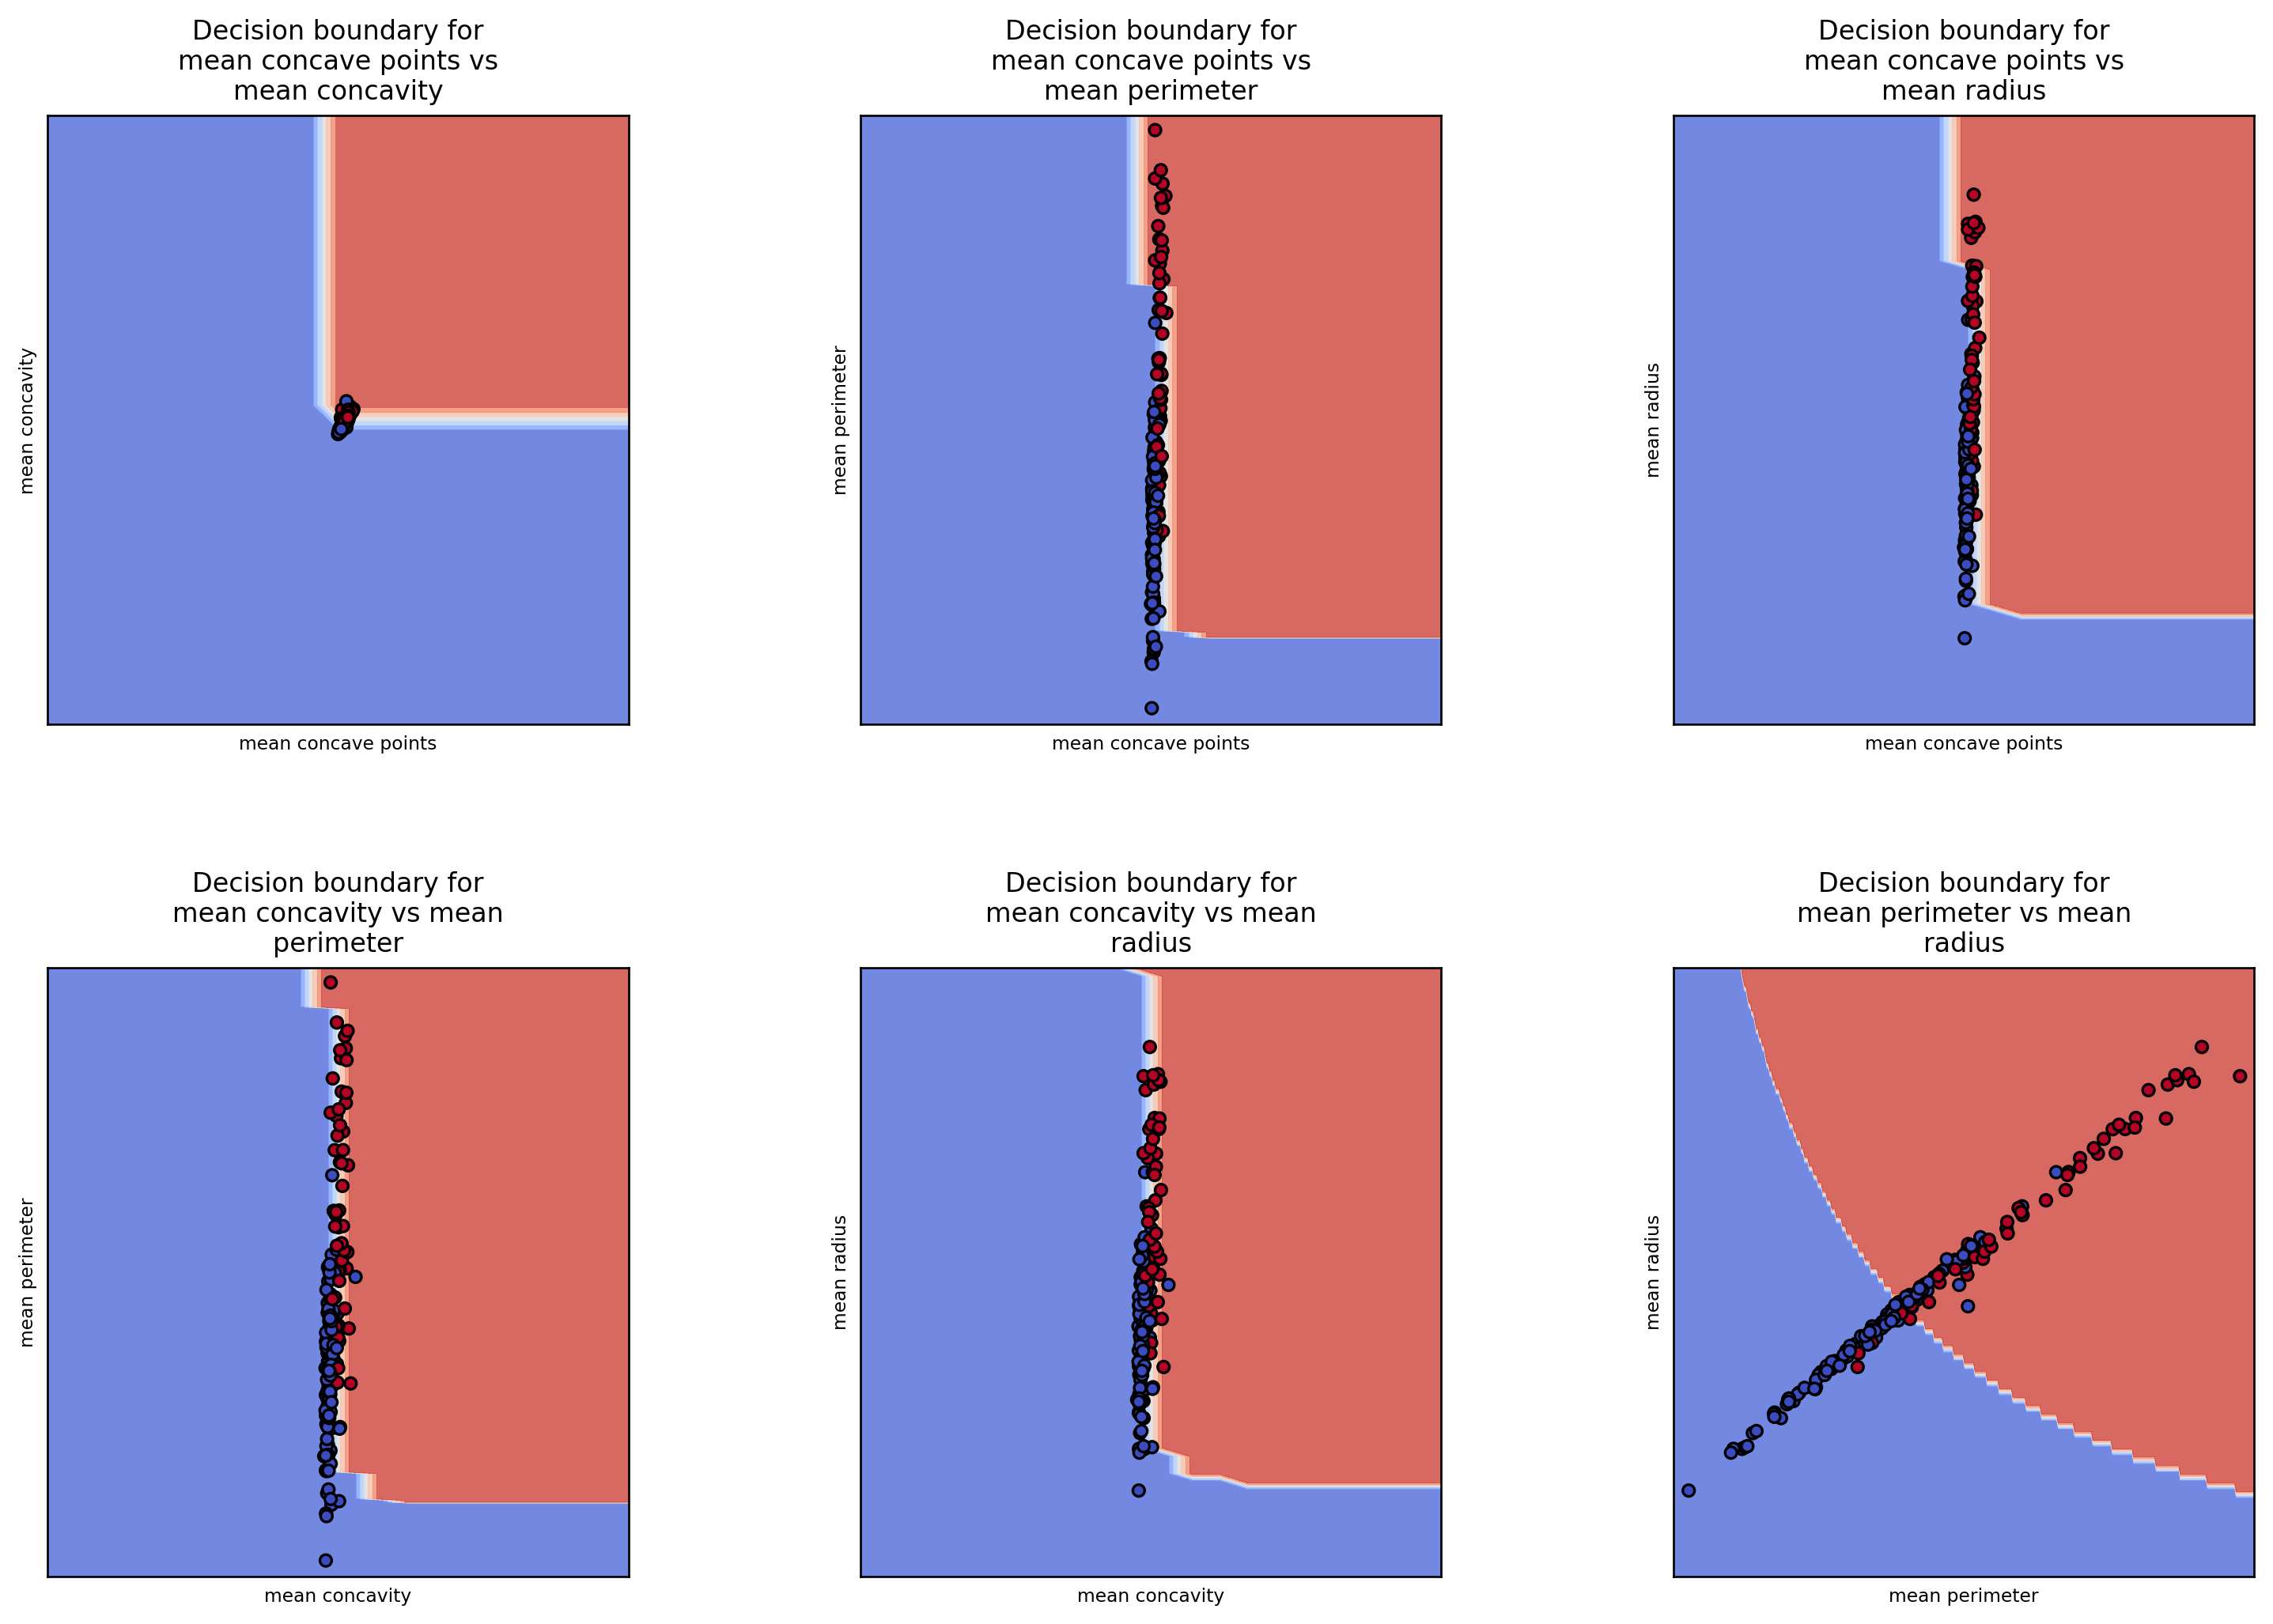

In [26]:
# Convert X_train to DataFrame if not already
X_train_df = pd.DataFrame(X_train, columns=features)

# Create an imputer instance for filling missing values
imputer = SimpleImputer(strategy='median')
# Apply imputer and keep data in DataFrame with feature names
X_train_imputed_df = pd.DataFrame(imputer.fit_transform(X_train_df), columns=X_train_df.columns)

# Reset index on y_train to ensure alignment (only if y_train is a pandas Series)
y_train.reset_index(drop=True, inplace=True)

# Calculate means to set up fixed values for other features in the prediction grid
xmean = {feature: 0.5 * (X_train_imputed_df.loc[y_train == 'malignant', feature].mean() + 
                         X_train_imputed_df.loc[y_train == 'benign', feature].mean()) for feature in features}

# Plot decision boundaries for each pair of top 4 features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

plot_num = 1
for i, feature1 in enumerate(top_4_features):
    for j, feature2 in enumerate(top_4_features):
        if i >= j:
            continue

        ax = axes[(plot_num - 1) // 3, (plot_num - 1) % 3]

        X0, X1 = X_train_imputed_df[feature1], X_train_imputed_df[feature2]

        # Create meshgrid
        x_min, x_max = X0.min() - 1, X0.max() + 1
        y_min, y_max = X1.min() - 1, X1.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

        # Predict classes for each point in the meshgrid, using a DataFrame to maintain feature names
        full_grid_df = pd.DataFrame(np.ones((xx.size, len(features))) * np.array(list(xmean.values())), columns=features)
        full_grid_df[feature1] = xx.ravel()
        full_grid_df[feature2] = yy.ravel()

        Z = svm_best_model.predict(full_grid_df)
        Z = np.where(Z == 'benign', 0, 1)
        Z = Z.reshape(xx.shape)

        # Plot decision boundary and scatter plot
        ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
        scatter_colors = y_train.map({'benign': 0, 'malignant': 1})
        ax.scatter(X0, X1, c=scatter_colors, cmap=plt.cm.coolwarm, s=20, edgecolors='k')

        ax.set_xlabel(feature1)
        ax.set_ylabel(feature2)
        ax.set_xticks(())
        ax.set_yticks(())

        wrapped_title = '\n'.join(textwrap.wrap(f'Decision boundary for {feature1} vs {feature2}', width=25))
        ax.set_title(wrapped_title, fontsize=10)

        plot_num += 1

plt.show()


### 4.3 Performance specification
**Does the final model meet the client's criteria?  Explain why or why not.** [100 words maximum]

Yes, the final model meets the client's criteria. The optimized SVM classifier achieved a recall of 0.92 for malignant cases, surpassing the client's requirement of at least 0.90 detection probability. Additionally, the false positive rate is 0.08, well within the client's tolerance of no more than 20% false positives. The decision boundaries illustrate that the model effectively distinguishes between benign and malignant tumors using the top features. Therefore, the model satisfies both performance specifications set by the client, ensuring accurate and reliable diagnosis for malignant breast cancer.